In [1]:
import sys
sys.path.append('../../PI_GP_regressor')

from main_class import PhysicsInformedGP_regressor
from kernels.kernel_poisson import gram_Matrix,k_ff, k_fu, k_uf, k_uu
import numpy as np

 c:\Users\leitg\anaconda3\Lib\site-packages\scipy\stats\_qmc.py:804: UserWarning:The balance properties of Sobol' points require n to be a power of 2.
 c:\Users\leitg\anaconda3\Lib\site-packages\scipy\stats\_qmc.py:804: UserWarning:The balance properties of Sobol' points require n to be a power of 2.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


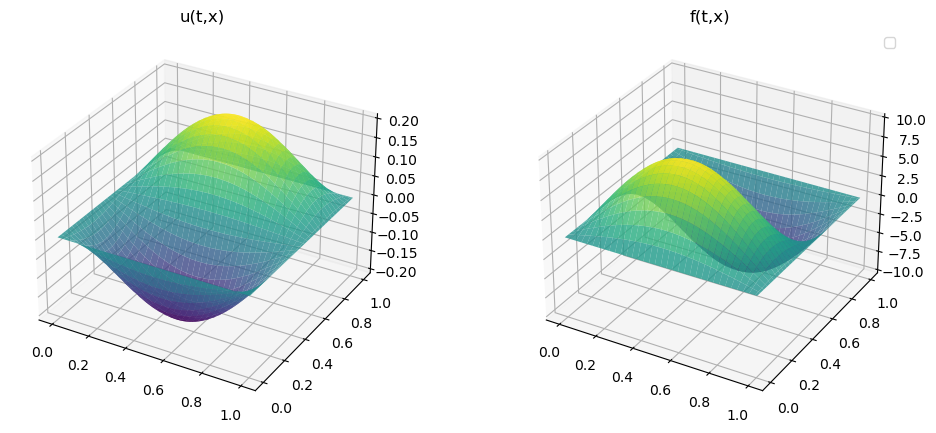

In [2]:
kernel_list = [gram_Matrix, k_uu, k_uf, k_fu, k_ff]
hyperparameters = ["l_x", "sigma_f"]
model = PhysicsInformedGP_regressor(kernel_list,timedependence=True, params = hyperparameters,Dimensions=2)
model.set_name_kernel("poisson")
n_training_points, noise_sq = 20, [1e-8,1e-8]
model.set_training_data("poisson_data.csv",n_training_points, noise_sq)
model.set_validation_data(2000)
model.plot_raw_data()

In [52]:
model.jitter = 1e-7
def get_initial_values():
    """returns the initial values for the hyperparameters
    for the length scales we initialize them randomly as log(l) ~ U(-1.3,1)
    """
    rng = np.random.default_rng()
    theta_initial = np.zeros((2))
    theta_initial[0] = np.exp(rng.uniform(-1.3, 0.4, 1))  #lx
    theta_initial[1] = rng.uniform(0, 1, 1)               #sigma_f              
    return theta_initial
n_restarts = 1000
n_threads = -1
opt_params_dict = {'theta_initial': get_initial_values,   #needed for all optimization methods
                    'bounds': ((1e-2, None), (1e-5, None)), #needed for TNC and L-BFGS-B
                    'gtol': 1e-7}
#model.train("Nelder-Mead",n_restarts, n_threads,opt_params_dict)
model.train("TNC",n_restarts, n_threads,opt_params_dict)

100%|██████████| 1000/1000 [00:45<00:00, 21.88it/s]


 message: Converged (|f_n-f_(n-1)| ~= 0)
 success: True
  status: 1
     fun: -10.493555068969727
       x: [ 4.417e-01  1.977e-01]
     nit: 4
     jac: [ 2.344e+00  1.664e+00]
    nfev: 98


In [53]:
n_test_points = 100
x_star, t_star = np.meshgrid(np.linspace(0, 1, n_test_points), np.linspace(0, 1, n_test_points))
X_star = np.hstack((x_star.flatten()[:, None], t_star.flatten()[:, None]))
model.predict_model(X_star)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


-----------------------------------------------
GP with kernel: 
Training data: (20, 2)
Training targets: (40, 1)
Hyperparameters: {'l_x': 0.44171141088008903, 'sigma_f': 0.19765841536561743}
Log marginal likelihood: -10.493555068969727
Mean squared error: {'u': 5.133150352776283e-06, 'f': 0.022402411326766014}
Relative l2 error: {'u': 0.022565288376629137, 'f': 0.030246819725358785}
-----------------------------------------------



 c:\Users\leitg\OneDrive - Technische Universität Graz\Dokumente\Uni\BAC\Code_bac\final_examples\poisson\../../PI_GP_regressor\main_class.py:723: RuntimeWarning:invalid value encountered in sqrt
 c:\Users\leitg\OneDrive - Technische Universität Graz\Dokumente\Uni\BAC\Code_bac\final_examples\poisson\../../PI_GP_regressor\main_class.py:732: RuntimeWarning:invalid value encountered in sqrt


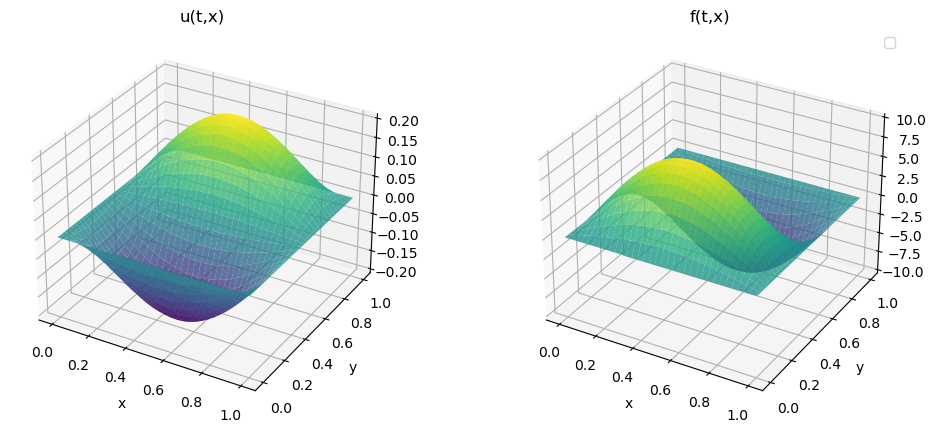

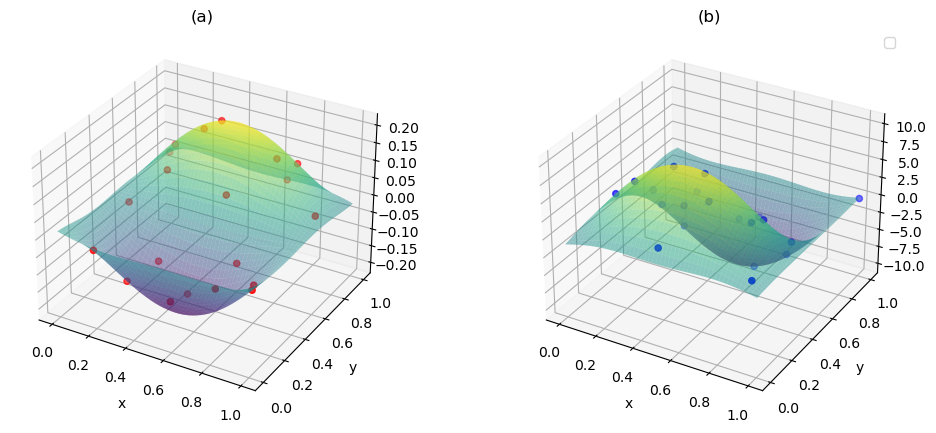

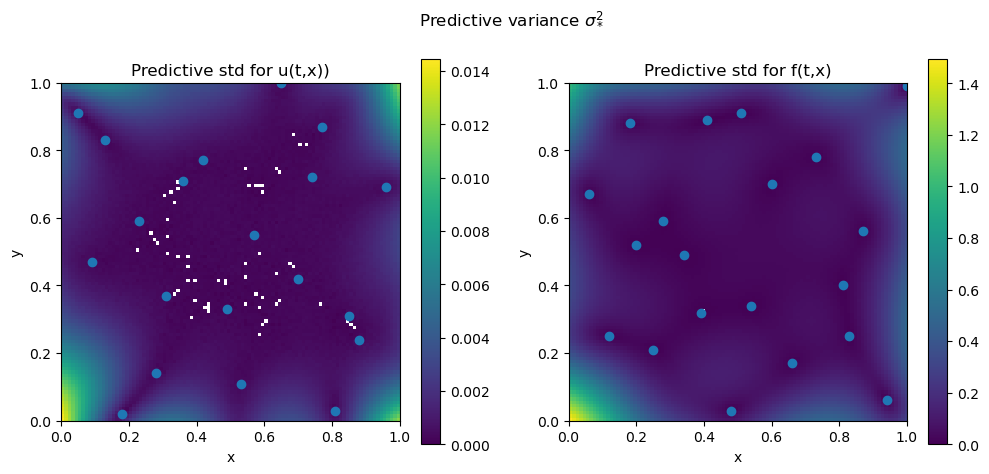

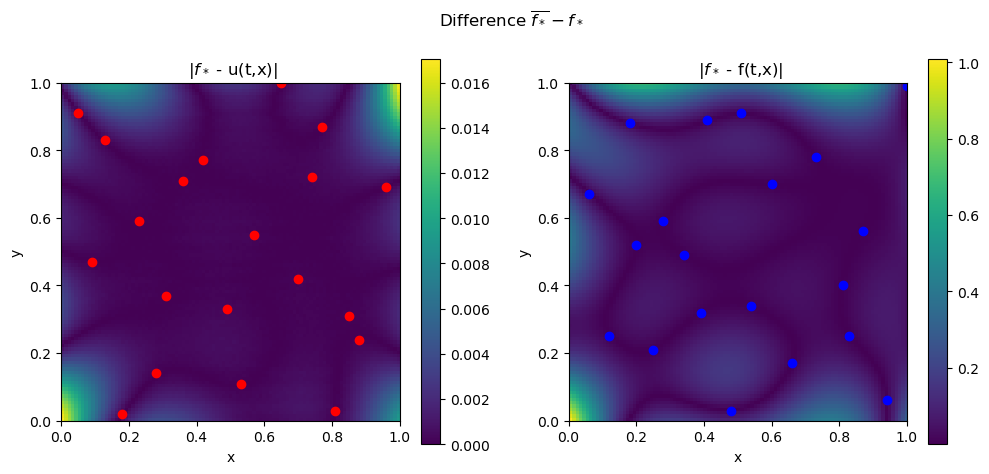

In [54]:
model.plot_raw_data(heat_map=False)
model.plot_prediction(X_star, "","predictive_mean.png",False)
model.error()
print(model)
model.plot_variance(X_star, "Predictive variance $\\sigma_*^2$", "predictive_variance.png")
model.plot_difference( "Difference $\\overline{ f_*} - f_*$", "difference.png")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


MSE_u:  6.382150108439327e-05
MSE_f:  0.1710785716639461
relative error u:  0.07963581543871837
relative error f:  0.08355052386535741


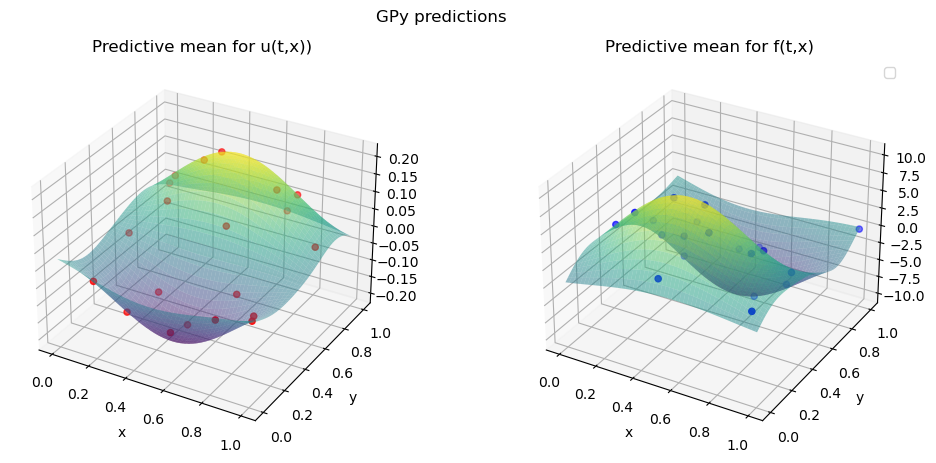

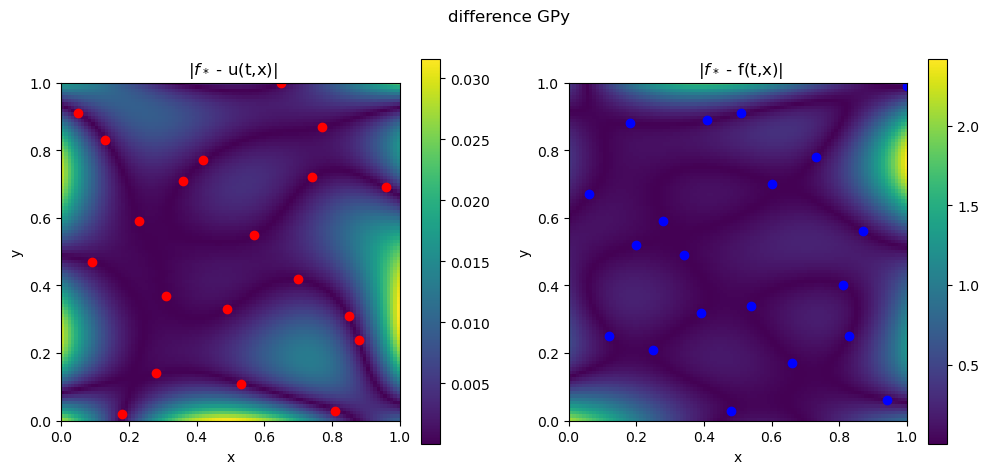

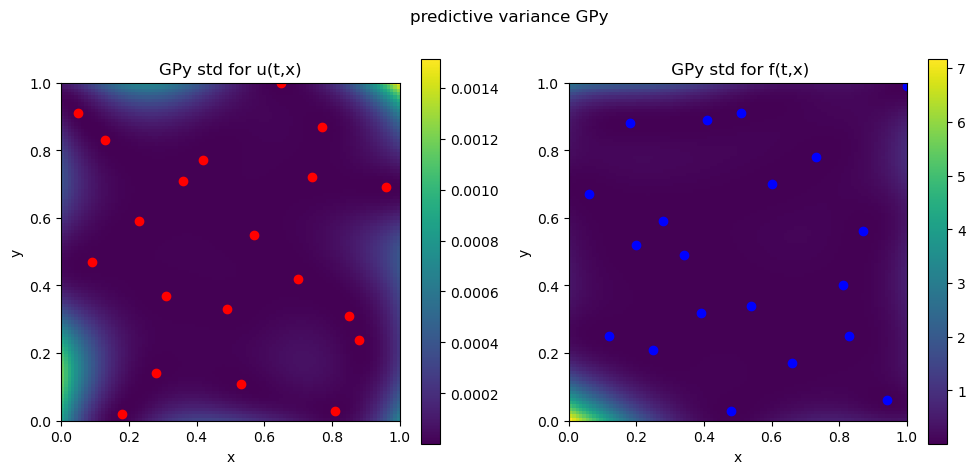

In [55]:
model.use_GPy(X_star,"gpy")

model.plot_difference_GPy("difference GPy ", "GPy_difference.png")
model.plot_variance_GPy("predictive variance GPy ", "GPy_variance.png")

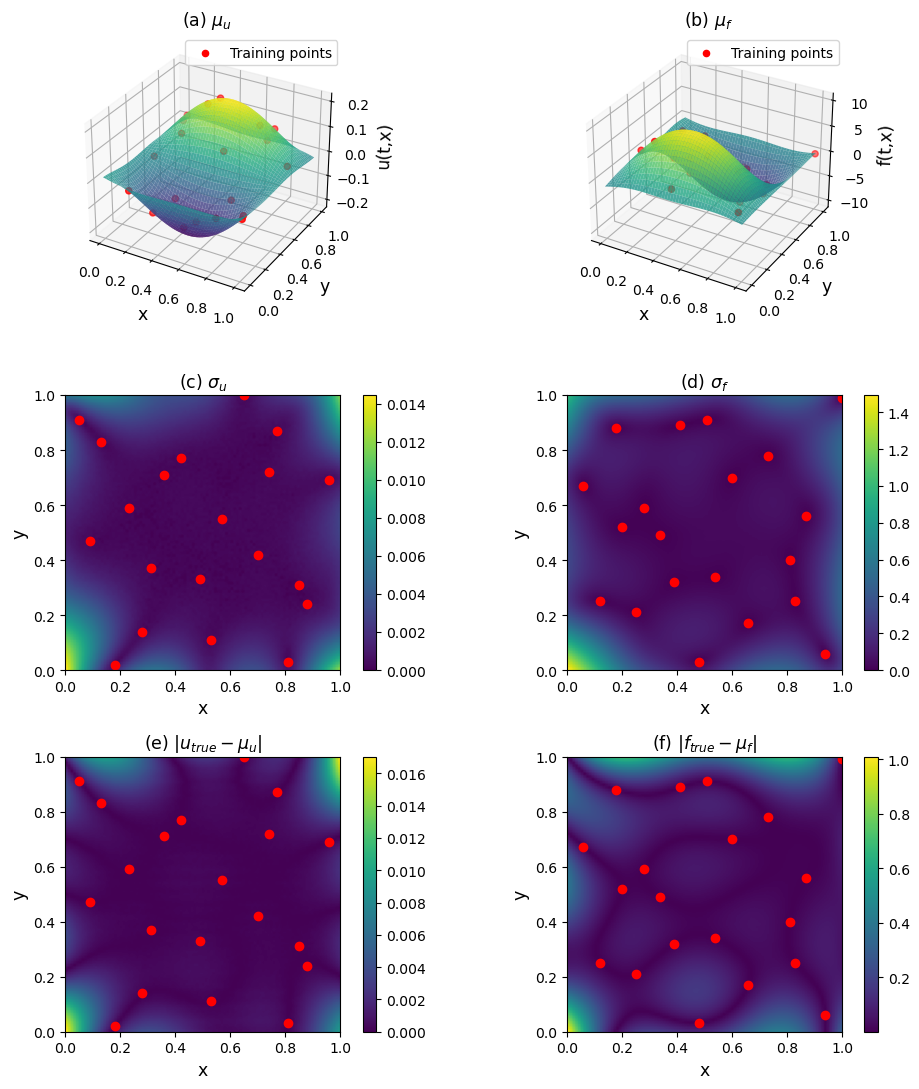

In [61]:
#model.set_axis_labels("x","t")
model.plot_merged_2d_plots(X_star,"merged_2d_plots.png",figsize=(10,11))


In [8]:
#model.plot_GPYmeandiff(X_star,"GPy_mean_diff.png",figsize=(10,9))

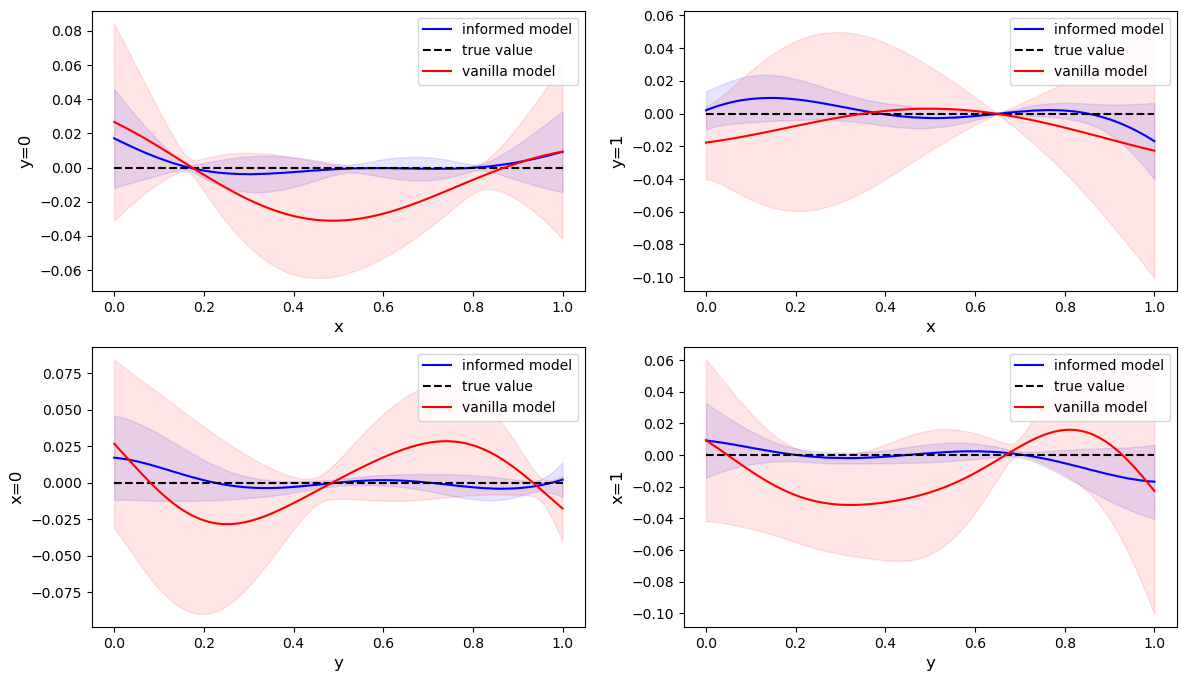

In [60]:
import matplotlib.pyplot as plt

axis = [0,0,1,1]
index = [0,100,0,100]
model.set_axis_labels("x","y")
#plot the 4 boundaries for bnoth the GP and the GPy
x_axis = np.c_[np.linspace(0,1,100),np.zeros(100)]
y_axis = np.c_[np.zeros(100),np.linspace(0,1,100)]
x1_axis = np.c_[np.ones(100),np.linspace(0,1,100)]
y1_axis = np.c_[np.linspace(0,1,100),np.ones(100)]

axis = [x_axis,y1_axis,y_axis,x1_axis]
labels = [["x","y=0"],["x","y=1"],["y","x=0"],["y","x=1"]]
fig, ax = plt.subplots(2, 2, figsize=(14, 8))
ax = ax.ravel()
for i in range(4):
   
    mean, var = model.predict_u(axis[i])
    mean_gpy, var_gpy = model.GPy_models[0].predict(axis[i])

    std = np.sqrt(var.ravel())
    std_gpy = np.sqrt(var_gpy.ravel())
    if i == 0 or i == 1:
        plot_axis = axis[i][:,0]
    else:
        plot_axis = axis[i][:,1]
    ax[i].plot(plot_axis,mean,"b",label="informed model")
    ax[i].plot(np.linspace(0,1,100),np.zeros(100),"k--",label="true value")
    ax[i].fill_between(plot_axis, mean.ravel()-2*std, mean.ravel()+2*std, color='blue', alpha=0.1)
    ax[i].plot(plot_axis,mean_gpy,"r",label="vanilla model")
    ax[i].fill_between(plot_axis, mean_gpy.ravel()-2*std_gpy, mean_gpy.ravel()+2*std_gpy, color='red', alpha=0.1)
    ax[i].set_xlabel(labels[i][0],fontsize=12)
    ax[i].set_ylabel(labels[i][1],fontsize=12)
    ax[i].legend()

plt.savefig("boundaries.png",bbox_inches='tight',dpi=300)

